# Optional exercise: Independent Component Analysis (ICA)



ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [3]:
!pip install mne
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

from pathlib import Path

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


Here is some quick preprocessing code of the raw data to get you started. Just run the chunk below and read the comments. 

In [16]:
# reading the file & loading in the data
own_data_raw_file = os.path.join(os.getcwd(), 'data', 'group10_own.vhdr')
raw = mne.io.read_raw_brainvision(own_data_raw_file, eog=('HEOG', 'VEOG'), misc=['41']) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = ['C3', 'Fp1', 'Fp2', 'F8'] # this was edited after checking the data out and seeing these channels were bad - 
raw.pick(['eeg', 'eog', 'misc'], exclude='bads')

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

raw.load_data()

# common average reference
raw.set_eeg_reference('average', projection=True)

# applying the reference
raw.apply_proj()


# high-pass 
# ICA is sensitive to slow drifts, therefore we are here using a high high-pass filter! 
# Note however, that when applying the ICA, we will do it to data high-pass filtered at 0.1 Hz
# See https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA
raw_fit = raw.copy().filter(1, None)

# low-pass 
raw_fit = raw_fit.filter(None, 40)

# high and low-pass filtering for the data not used to fit the ICA
raw = raw.filter(0.1, None)

# low-pass 
raw = raw.filter(None, 40)

Extracting parameters from /work/AkaranSivakumar#4825/CogNeuro24/own_experiment/data/group10_own.vhdr...
Setting channel info structure...
Reading 0 ... 852979  =      0.000 ...   852.979 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


In [10]:
input_path = os.path.join(os.getcwd(), 'epochs')
filename = "epochs-exam.fif"

epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)

Reading /work/AkaranSivakumar#4825/CogNeuro24/own_experiment/epochs/epochs-exam.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
629 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_14168/2952369976.py:4: RuntimeWarning: This filename (/work/AkaranSivakumar#4825/CogNeuro24/own_experiment/epochs/epochs-exam.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)


In [11]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter='auto')
ica.fit(raw)
ica

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 6 components
Fitting ICA took 4.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,13 iterations on raw data (852980 samples)
ICA components,6
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


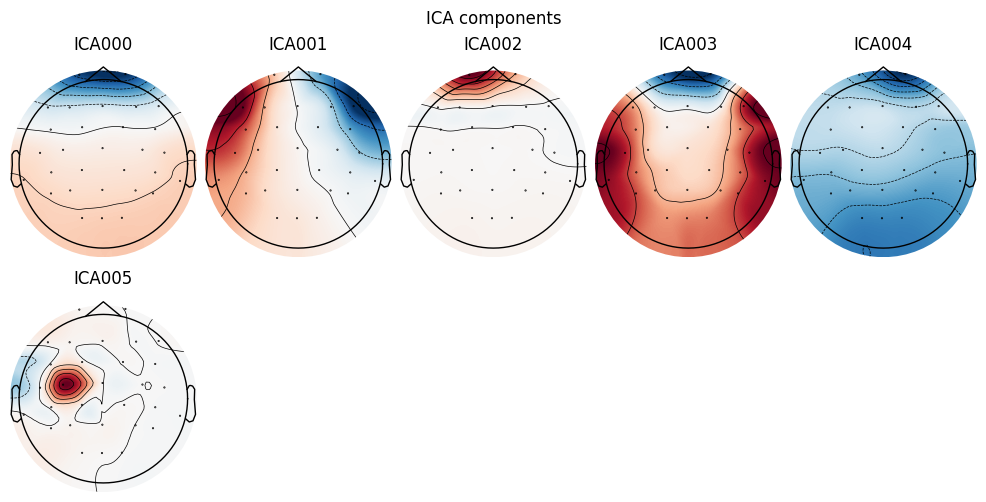

In [12]:
ica.plot_components();

Creating RawArray with float64 data, n_channels=8, n_times=852980
    Range : 0 ... 852979 =      0.000 ...   852.979 secs
Ready.


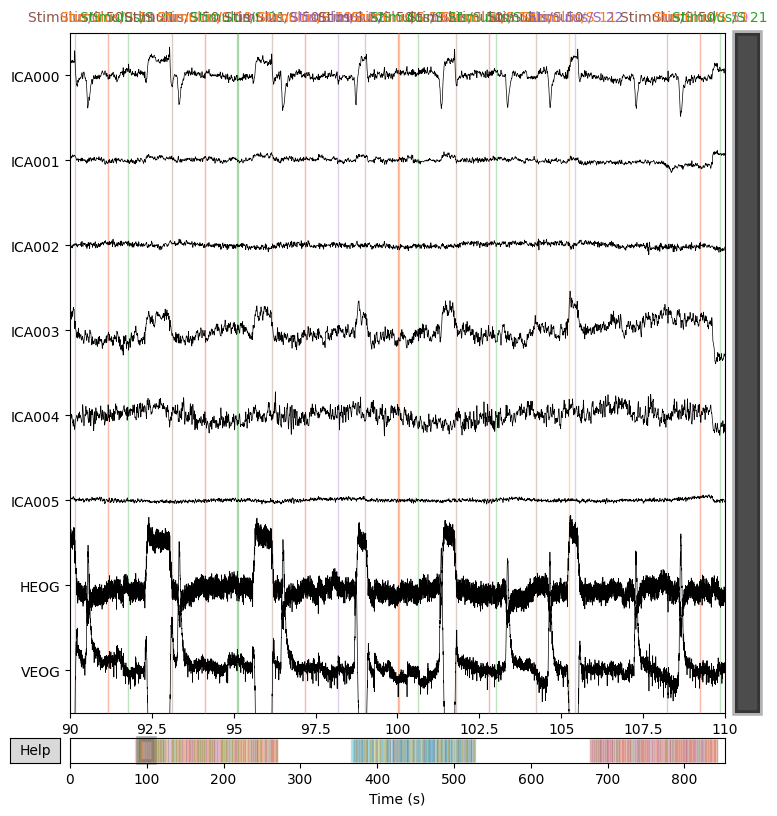

In [13]:
ica.plot_sources(raw, start=90);

In [14]:
ica.exclude = [0]
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


Measurement date,"February 29, 2024 11:29:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,33 points
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


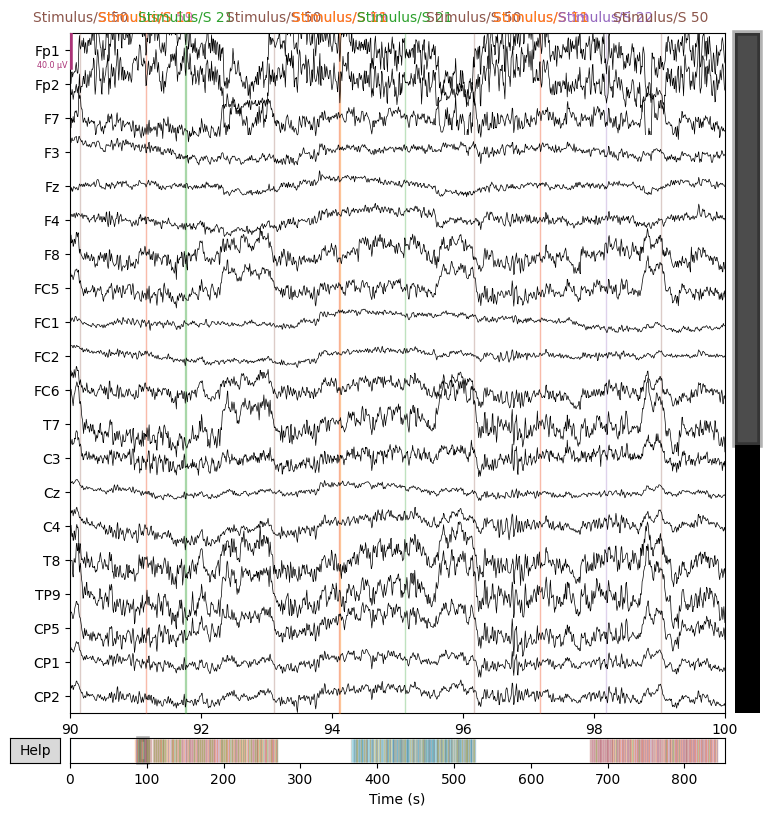

In [15]:
raw.plot(start=90);

In [37]:
import os

output_path = os.path.join(os.getcwd(), "preprocessed_data")

# make sure output path exists 
if not os.path.exists(output_path):
    os.mkdir(output_path)

raw.save(os.path.join(output_path, 'preprocessed_data_ica.fif'), overwrite=True)

Writing /work/AkaranSivakumar#4825/CogNeuro24/own_experiment/preprocessed_data/preprocessed_data_ica.fif


/tmp/ipykernel_1334/2531130584.py:9: RuntimeWarning: This filename (/work/AkaranSivakumar#4825/CogNeuro24/own_experiment/preprocessed_data/preprocessed_data_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(os.path.join(output_path, 'preprocessed_data_ica.fif'), overwrite=True)


Closing /work/AkaranSivakumar#4825/CogNeuro24/own_experiment/preprocessed_data/preprocessed_data_ica.fif
[done]
